# 10. Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
# !wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from extras.helper_functions import create_tensorboard_callback, calculate_results, compare_historys, plot_loss_curves
import tensorflow as tf

%matplotlib inline
tf.__version__

'2.9.1'

## Machine Learning Engineer

1. Download a paper
2. Implement it
3. Keep doing this until you have skills

Raw Abstract Text -> Model (SkimLit) -> Model predicts topic of each sequence

## What we're going to cover

* Downloading a text dataset (PubMed 200K RCT)
* Writing a preprocessing function for our data
* Setting up multiple modelling experiments with different levels of embeddings
* Building a multimodal model to take in different sources of data
    * Replicating the model powering https://arxiv.org/abs/1710.06071
* Finding the most wrong prediction examples

What section should a sentence belong to? -> SkimLit -> Class [Background, Objective, Methods, Results, Conclusion]

In [18]:
!nvidia-smi

Thu Jul 21 08:36:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8     7W /  N/A |   4277MiB /  6144MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data 

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [19]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct

In [20]:
# import shutil

# shutil.move("pubmed-rct", "Data/NLP/SkimLit")

In [21]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign"
# data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [22]:
os.listdir(data_dir)

['dev.txt', 'test.txt', 'train.txt']

In [23]:
filenames = [data_dir + "/" +file for file in os.listdir(data_dir)]
filenames

['Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocessing Data

### Method 1: Using Tensors

In [24]:
train_dataset = tf.data.TextLineDataset([data_dir + "/train.txt"])
val_dataset = tf.data.TextLineDataset([data_dir + "/dev.txt"])
test_dataset = tf.data.TextLineDataset([data_dir + "/test.txt"])

In [25]:
def remove_data(ds):
    return ds.filter(lambda x: tf.strings.regex_full_match(x, "#{3}[0-9]{8}") == False and tf.strings.length(x) != 0)

def preprocess_data(line):
    data = tf.strings.strip(tf.strings.regex_replace(line, "^[A-Z]+", ""))
    return data

def preprocess_labels(line):
    label = tf.strings.regex_replace(line, r"[^A-Z]+\S+","")
    return label

def data_preparation(dataset):
    return dataset.apply(remove_data).map(map_func = preprocess_data, num_parallel_calls = tf.data.AUTOTUNE), dataset.apply(remove_data).map(map_func = preprocess_labels, num_parallel_calls = tf.data.AUTOTUNE)

In [26]:
train_data, train_labels = data_preparation(train_dataset)
val_data, val_labels = data_preparation(val_dataset)
test_data, test_labels = data_preparation(test_dataset)

However this has a major drawback in that it becomes agnostic to the abstract ID.

### Method 2

Before going to method 2, lets take a small detour.

In [27]:
for data, label in zip(train_data.as_numpy_iterator(), train_labels.as_numpy_iterator()):
    print(data, label)
    break

b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .' b'OBJECTIVE'


In [28]:
import re
def read_files(filepath):
    data_dir = "Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign"
    files = [data_dir + "/" + file for file in os.listdir(data_dir)]
    abstract_idx = ""
    filepath = files[filepath]
    with open(filepath) as file:
        for line in file.readlines():
            if re.search(r"#{3}[0-9]{8}", line) != None:
                continue
            elif len(line) == 0:
                continue
            label = re.search(r"^[A-Z]+", line)
            if label != None:
                label = label[0]
                data = line.replace(label, "").strip()
                yield data, label

i = 0
for data, label in read_files(2):
    print(data, label)
    print("*"*80)
    i += 1
    if i == 10:
        break

To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) . OBJECTIVE
********************************************************************************
A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks . METHODS
********************************************************************************
Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers . METHODS
********************************************************************************
Pain was assessed using the visual analog pain scale ( @-@ mm ) . METHODS
********************************************************************************
Secondary outcome measures included the West

In [29]:
train_dataset_prepared = tf.data.Dataset.from_generator(lambda: read_files(2), output_types = (tf.string, tf.string), output_shapes = (None, None))
for data, label in train_dataset_prepared.as_numpy_iterator():
    print(data, label)
    break

b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .' b'OBJECTIVE'


The above is another alternative to get data. However, since it relies on a generator, it's inherently slower than method 1.

Let's think about how we want our data to look...

The best way to represent our data would be akin to

```
[
    {
        'line_number': 0,
        'target': 'BACKGROUND',
        'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
        'total_lines': 11
    }, ....
]
```

In [30]:
def get_lines(filepath):
    with open(filepath) as file:
        return file.readlines()

def preprocess_text_with_line_numbers(filepath):
    """
    Returns a list of dictionaries of abstract line data

    Takes in a filename, reads its contents and sorts through each line, extracting things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
    """
    input_lines = get_lines(filepath) # get all lines from filename
    abstract_lines = " # create an empty abstract"
    abstract_samples = [] # create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            # Iterate through each line in a particular abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it.
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many lines are there in the target abstract? (start from 0)
                abstract_samples.append(line_data)
        else: # if the above conditions arent fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples


In [31]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [32]:
# Check the first abstract of our trainining data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the form of a list of dictionaries, how about we turn it into a DataFrame to further visualise it.

In [33]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [34]:
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [35]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

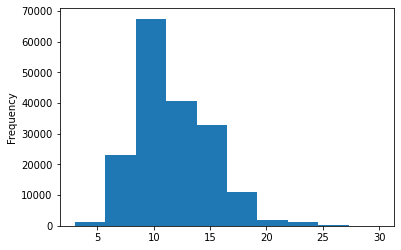

In [36]:
# Lets check the length of different lines
train_df.total_lines.plot.hist();

## Get lists of sentences

In [37]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [38]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [39]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False) # we want non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

### Label encode labels

In [40]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [41]:
# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [42]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments we're running
|Experiment|Model|
|----------|-----|
|0|Naive Bayes with TF-IDF encoder (baseline)|
|1|Conv1D with token embeddings|
|2|TensorFlow Pretrained Feature Extractor|
|3|Conv1D with character embeddings|
|4|Pretrained token embeddings (same as 2) + character embeddings (same as 3)|
|5|Pretrained token embeddings + character embeddings + positional embeddings|

## Starting with a series of modelling experiments...

As usual we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier)

## Model 0: Naive Bayes with TF-IDF encoder 

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline(
    [
        ('tf_idf_vectorizer', TfidfVectorizer()),
        ('classifier_layer', MultinomialNB())
    ]
)

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf_idf_vectorizer', TfidfVectorizer()),
                ('classifier_layer', MultinomialNB())])

In [44]:
model_0_preds = model_0.predict(val_sentences)
baseline_results = calculate_results(val_labels_encoded, model_0_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [45]:
from extras.helper_functions import make_confusion_matrix

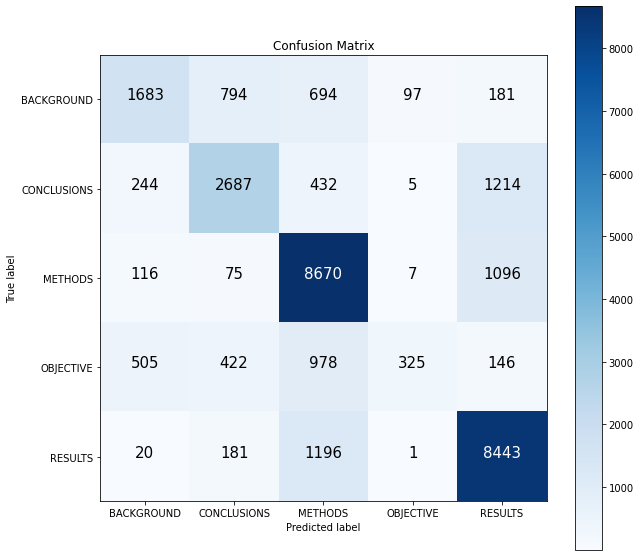

In [46]:
make_confusion_matrix(val_labels_encoded, model_0_preds, classes = list(class_names))

## Model 1: Conv1D with token embeddings

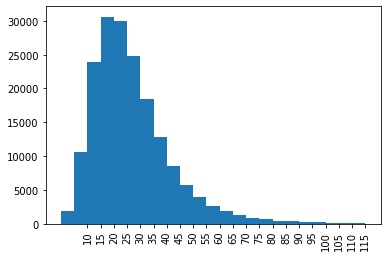

In [47]:
plt.hist([len(sentence.split()) for sentence in train_sentences], bins = np.arange(0, 120, 5));
plt.xticks(np.arange(10, 120, 5), rotation = 90);
# plt.axvline(110, color = "black");
plt.show();

In [48]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile([len(sentence.split()) for sentence in train_sentences], 95))
output_seq_len

55

In [49]:
# Maximum sequence length in the training set
max([len(sentence.split()) for sentence in train_sentences])

296

We want to make a layer which maps our texts from words to numbers. We need to answer how many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)

In [50]:
MAX_TOKENS = 68000
SEQUENCE_LENGTH = 55

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = MAX_TOKENS,
    output_sequence_length = SEQUENCE_LENGTH,
    output_mode = "int",
    name = "text_vectorizer_layer"
)

text_vectorizer.adapt(train_sentences)

In [51]:
import random

target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer(target_sentence)}')

Text:
in the early post-operative period , @ % of hs patients and @ % of ci cases showed no facial nerve impairment ( p = @ ) .

Length of text: 28

Vectorized text: [   5    2  224  163  173    4 2399   12    3    4   50  263  147   33
 1704  892  798   14    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [52]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [53]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorizer_layer',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create a Text Embedding

In [54]:
embedding = tf.keras.layers.Embedding(input_dim = len(text_vectorizer.get_vocabulary()),
                                      output_dim = 128,
                                      input_length = SEQUENCE_LENGTH,
                                      mask_zero = True,
                                      name = "embedding")
embedding(text_vectorizer([target_sentence]))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.03650494,  0.0155139 , -0.04517552, ..., -0.01970026,
         -0.01593947, -0.01763958],
        [-0.03171684, -0.02325544,  0.01434047, ..., -0.02963921,
          0.03449775,  0.0230079 ],
        [-0.03962709,  0.00320603, -0.02739735, ...,  0.01409984,
         -0.00208193,  0.0485684 ],
        ...,
        [-0.01287768,  0.04079613, -0.01503116, ...,  0.03831521,
         -0.00454333, -0.0239677 ],
        [-0.01287768,  0.04079613, -0.01503116, ...,  0.03831521,
         -0.00454333, -0.0239677 ],
        [-0.01287768,  0.04079613, -0.01503116, ...,  0.03831521,
         -0.00454333, -0.0239677 ]]], dtype=float32)>

### Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [55]:
# Turn our data into TensorFlow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [56]:
# Take the TensorSliceDataset's and turn it into prefetched datasets

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [57]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Building, Compiling and Fitting the model

In [58]:
SAVE_DIR = "TensorBoard/SkimLit"
# SAVE_DIR = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/TensorBoard/SkimLit"

In [59]:
# Build the model
model_1 = tf.keras.Sequential(
    [
        text_vectorizer,
        embedding,
        tf.keras.layers.Conv1D(64, kernel_size = 5, activation = "relu", name = "conv1d_layer"),
        tf.keras.layers.GlobalMaxPooling1D(name = "pooling_layer"),
        tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")
    ], name = "model_1_conv1d"
)

# Compile the model
model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_1 = model_1.fit(
    train_dataset,
    epochs = 3, # set to 3 for faster training
    steps_per_epoch = int(0.1*len(train_dataset)), # to rapidly prototype, set to int(0.1 * len(train_dataset))
    validation_data = valid_dataset,
    validation_steps = int(0.1 * len(valid_dataset)), # to rapidly prototype, set to int(0.1 * len(valid_dataset))
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_1_conv1d")]
)

Saving TensorBoard log files to: TensorBoard/SkimLit/model_1_conv1d/20220721-083653
Epoch 1/3
562/562 [==============================] - 17s 11ms/step - loss: 0.8402 - accuracy: 0.6826 - val_loss: 0.5938 - val_accuracy: 0.7793
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.5859 - accuracy: 0.7867 - val_loss: 0.5485 - val_accuracy: 0.7952
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.5531 - accuracy: 0.7952 - val_loss: 0.5265 - val_accuracy: 0.8015


In [60]:
model_1_preds = tf.squeeze(tf.argmax(model_1.predict(valid_dataset), axis = 1))

945/945 [==============================] - 3s 3ms/step


In [61]:
val_labels = []
for _, labels in valid_dataset.unbatch():
    val_labels.append(labels)

model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 80.18337084602145,
 'precision': 0.8009132613884711,
 'recall': 0.8018337084602145,
 'f1': 0.8004339540693292}

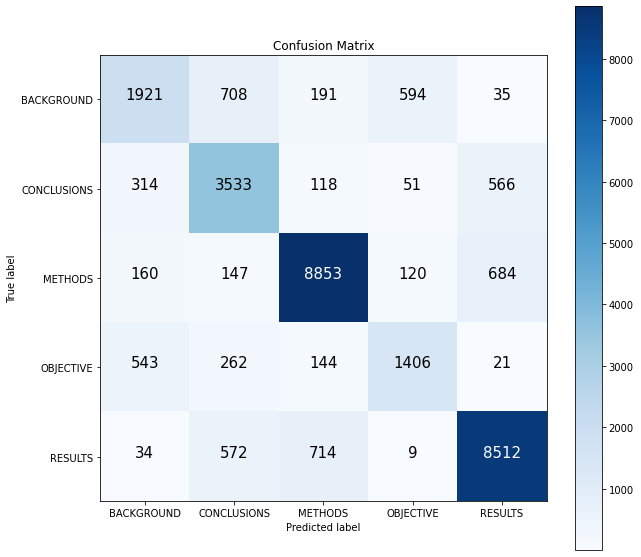

In [62]:
make_confusion_matrix(tf.argmax(val_labels, axis = 1), model_1_preds, classes = list(class_names))

## Model 2: TensorFlow Pretrained Feature Extractor

The paper uses GloVe embeddings. However, we're going to stick with the USE pre-trained embeddings we used earlier

In [63]:
import tensorflow_hub as hub
feature_extractor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable = False,
    input_shape = [],
    dtype = tf.string,
    name = "USE"
)

model_2 = tf.keras.Sequential(
    [
        feature_extractor,
        tf.keras.layers.Dense(128, activation = "relu", name = "hidden_layer_dense"),
        tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")
    ], name = "model_2"
)

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 hidden_layer_dense (Dense)  (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [64]:
# Compile the model
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_2 = model_2.fit(
    train_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1 * len(train_dataset)),
    validation_data = valid_dataset,
    validation_steps = int(0.1 * len(valid_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_2_USE")]
)

Saving TensorBoard log files to: TensorBoard/SkimLit/model_2_USE/20220721-083741
Epoch 1/3
562/562 [==============================] - 17s 23ms/step - loss: 0.9137 - accuracy: 0.6519 - val_loss: 0.7950 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 13s 23ms/step - loss: 0.7679 - accuracy: 0.7016 - val_loss: 0.7543 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 12s 22ms/step - loss: 0.7511 - accuracy: 0.7125 - val_loss: 0.7391 - val_accuracy: 0.7148


In [65]:
model_2_preds = tf.squeeze(tf.argmax(model_2.predict(valid_dataset), axis = 1))

945/945 [==============================] - 15s 16ms/step


In [66]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.33589302264001,
 'precision': 0.7137068849898403,
 'recall': 0.7133589302264001,
 'f1': 0.7102849942431025}

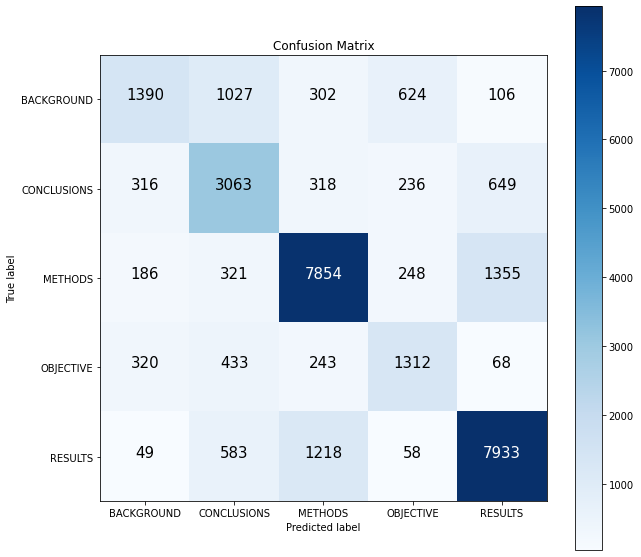

In [67]:
make_confusion_matrix(tf.argmax(val_labels, axis = 1), model_2_preds, classes = list(class_names))

## Model 3: Conv1D with character embeddings

The paper which we're replicating states that they used a combination of token and character level embeddings.

Previously we've taken token level embeddings. Now we'll do similar steps for character level embeddings

### Creating a character-level tokenizer

In [68]:
# Make function to split sentences into characters

def split_chars(text):
    """
    """
    temp = list(text)
    return " ".join(temp)

In [69]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [70]:
# Whats the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [71]:
output_seq_char_len = np.percentile(char_lens, 95)
output_seq_char_len

290.0

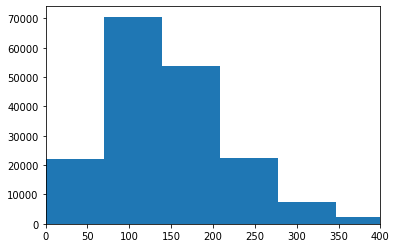

In [72]:
plt.hist(char_lens, bins = 20);
plt.xlim(0, 400);

In [73]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = NUM_CHAR_TOKENS,
    # standardize = None, # set standardization to None if you want to retain punctuations.
    output_sequence_length = int(output_seq_char_len),
    name = "char_vectorizer"
)

In [75]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [76]:
# Without standardization
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters in character vocab: {char_vocab[:5]}')
print(f'5 least common characters in character vocab: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters in character vocab: ['', '[UNK]', 'e', 't', 'i']
5 least common characters in character vocab: ['k', 'x', 'z', 'q', 'j']


In [77]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters in character vocab: {char_vocab[:5]}')
print(f'5 least common characters in character vocab: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters in character vocab: ['', '[UNK]', 'e', 't', 'i']
5 least common characters in character vocab: ['k', 'x', 'z', 'q', 'j']


In [78]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n{random_train_chars}')
print(f'Length of random_train_chars: {len(random_train_chars)}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n{vectorized_chars}')
print(f'\nLength of Vectorized chars:{len(vectorized_chars[0])}')

Charified text:
b i o e q u i v a l e n c e   w a s   a s s e s s e d   b a s e d   o n   @   %   c o n f i d e n c e   i n t e r v a l s   ,   a c c o r d i n g   t o   t w o   o n e - s i d e d   t - t e s t s   .
Length of random_train_chars: 199

Vectorized chars:
[[22  4  7  2 26 16  4 21  5 12  2  6 11  2 20  5  9  5  9  9  2  9  9  2
  10 22  5  9  2 10  7  6 11  7  6 17  4 10  2  6 11  2  4  6  3  2  8 21
   5 12  9  5 11 11  7  8 10  4  6 18  3  7  3 20  7  7  6  2  9  4 10  2
  10  3  3  2  9  3  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [79]:
char_embedding = tf.keras.layers.Embedding(
    input_dim = len(char_vocab),
    input_length = output_seq_char_len,
    output_dim = 25, # this is the size of the char embedding in the paper
    name = "char_embed"
)

In [80]:
# Test our character embedding layer
print(f'Charified text:\n{random_train_chars}\n')
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n{char_embed_example}\n')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text:
b i o e q u i v a l e n c e   w a s   a s s e s s e d   b a s e d   o n   @   %   c o n f i d e n c e   i n t e r v a l s   ,   a c c o r d i n g   t o   t w o   o n e - s i d e d   t - t e s t s   .

Embedded chars (after vectorization and embedding):
[[[ 0.00240527  0.01506522  0.02907619 ...  0.00776384 -0.04923114
   -0.02372929]
  [ 0.02940625 -0.01406591 -0.01384173 ...  0.02115412 -0.04208823
    0.00654392]
  [ 0.00337716  0.04632494  0.01357846 ... -0.02008917 -0.02728907
   -0.04797628]
  ...
  [ 0.02494638 -0.04164159 -0.02760898 ...  0.00177805 -0.0302922
   -0.00874228]
  [ 0.02494638 -0.04164159 -0.02760898 ...  0.00177805 -0.0302922
   -0.00874228]
  [ 0.02494638 -0.04164159 -0.02760898 ...  0.00177805 -0.0302922
   -0.00874228]]]

Character embedding shape: (1, 290, 25)


### Building Conv1D model

In [81]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = "string", name = "input_layer")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu", name = "conv1d_layer")(char_embeddings)
x = tf.keras.layers.GlobalMaxPool1D(name = "max_pool_layer")(x)
outputs = tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_char_level_conv1d")

# Compile the model
model_3.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_3.summary()

Model: "model_3_char_level_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_layer (Conv1D)       (None, 290, 64)           8064      
                                                                 
 max_pool_layer (GlobalMaxPo  (None, 64)               0         
 oling1D)                                                        
                                                                 
 output_layer (Dense)        (None, 5)   

In [82]:
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [83]:
# Fit the model
history_model_3 = model_3.fit(
    train_chars_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1 * len(train_chars_dataset)),
    validation_data = val_chars_dataset,
    validation_steps = int(0.1 * len(val_chars_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_3_Conv1D_char")]
)

Saving TensorBoard log files to: TensorBoard/SkimLit/model_3_Conv1D_char/20220721-083855
Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2534 - accuracy: 0.4813 - val_loss: 1.0532 - val_accuracy: 0.5765
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0236 - accuracy: 0.5873 - val_loss: 0.9566 - val_accuracy: 0.6210
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.9354 - accuracy: 0.6304 - val_loss: 0.8802 - val_accuracy: 0.6602


In [84]:
model_3_preds = tf.squeeze(tf.argmax(model_3.predict(val_chars_dataset), axis = 1))

945/945 [==============================] - 3s 3ms/step


In [85]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 64.68621739706077,
 'precision': 0.6458667844714854,
 'recall': 0.6468621739706077,
 'f1': 0.6366592303905292}

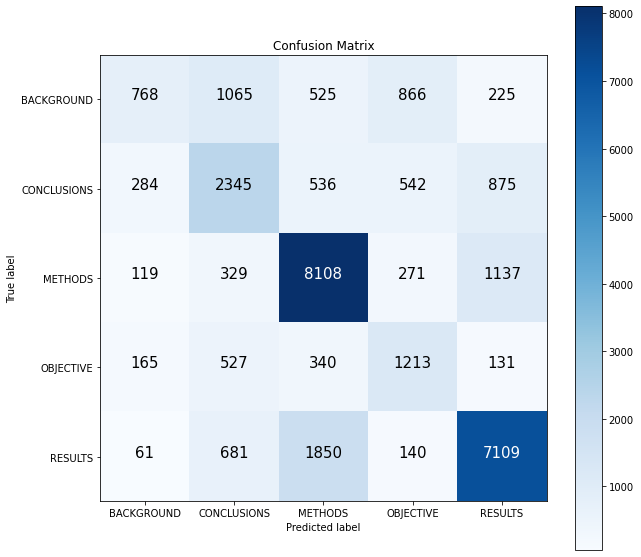

In [86]:
make_confusion_matrix(tf.argmax(val_labels, axis = 1), model_3_preds, classes = list(class_names))

## Model 4: Combining Pretrained Token + Character Level Embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 and 2 with a concatenation (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [87]:
# 1. Setup token inputs/model
token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embeddings = feature_extractor(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = "relu", name = "token_outputs")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Setup char inputs/model
char_inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name = "token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers -adding in Dropout, discussed
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input], outputs = output_layer, name = "model_4_token_and_char_embeddings")

In [88]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   [

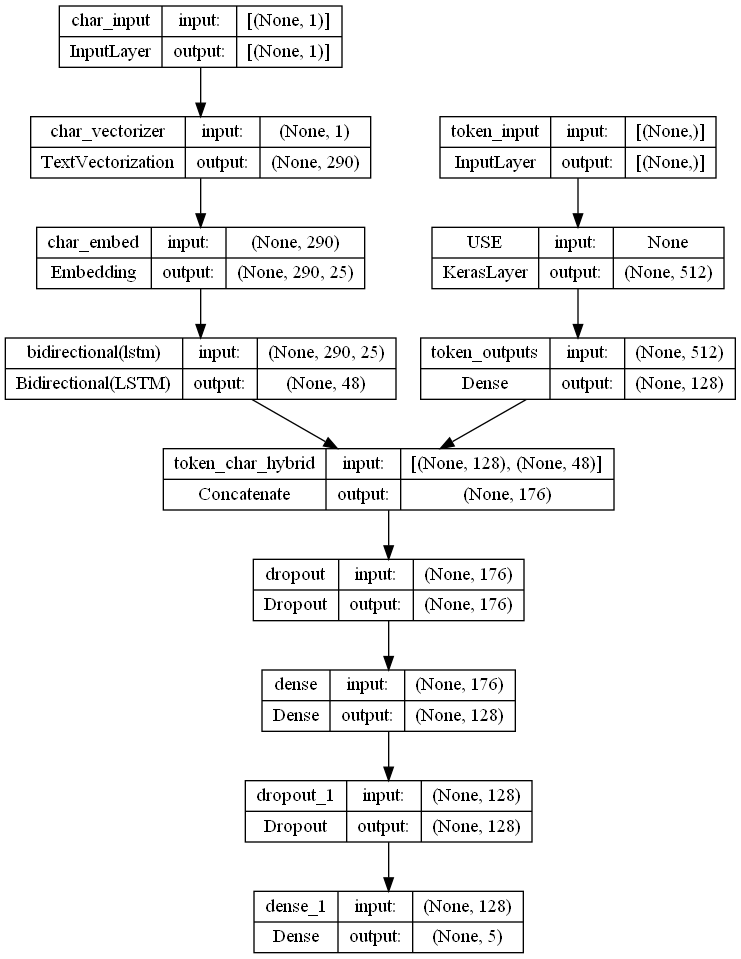

In [89]:
from tensorflow.keras.utils import plot_model

plot_model(model_4, show_shapes = True)

In [90]:
# Compile token char model
model_4.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

### Combining token and character data into a tf.data Dataset

In [91]:
def construct_dataset(token_sequence, char_sequence, label_data, batch_size = 32):
    data = tf.data.Dataset.from_tensor_slices((token_sequence, char_sequence))
    labels = tf.data.Dataset.from_tensor_slices(label_data)
    dataset = tf.data.Dataset.zip((data, labels))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [92]:
# train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
# train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels

# train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# # Prefetch and batch train_data
# train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_dataset = construct_dataset(train_sentences, train_chars, train_labels_one_hot)

In [93]:
val_char_token_dataset = construct_dataset(val_sentences, val_chars, val_labels_one_hot)
test_char_token_dataset = construct_dataset(test_sentences, test_chars, test_labels_one_hot)

In [94]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [95]:
# Fit the model
history_model_4 = model_4.fit(
    train_char_token_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
    validation_data = val_char_token_dataset,
    validation_steps = int(0.1 * len(val_char_token_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "char_token_model_4")]
)

Saving TensorBoard log files to: TensorBoard/SkimLit/char_token_model_4/20220721-083917
Epoch 1/3
562/562 [==============================] - 43s 54ms/step - loss: 0.9834 - accuracy: 0.6085 - val_loss: 0.7780 - val_accuracy: 0.6965
Epoch 2/3
562/562 [==============================] - 28s 51ms/step - loss: 0.8007 - accuracy: 0.6948 - val_loss: 0.7119 - val_accuracy: 0.7384
Epoch 3/3
562/562 [==============================] - 31s 55ms/step - loss: 0.7772 - accuracy: 0.7033 - val_loss: 0.6905 - val_accuracy: 0.7404


In [96]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 32s 33ms/step - loss: 0.6943 - accuracy: 0.7351


[0.6942517161369324, 0.735072135925293]

In [97]:
# Make predictions using the token-charater model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.squeeze(tf.argmax(model_4_pred_probs, axis = 1))
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

945/945 [==============================] - 26s 26ms/step


{'accuracy': 73.50721567589036,
 'precision': 0.7359937059565408,
 'recall': 0.7350721567589037,
 'f1': 0.7323617786037788}

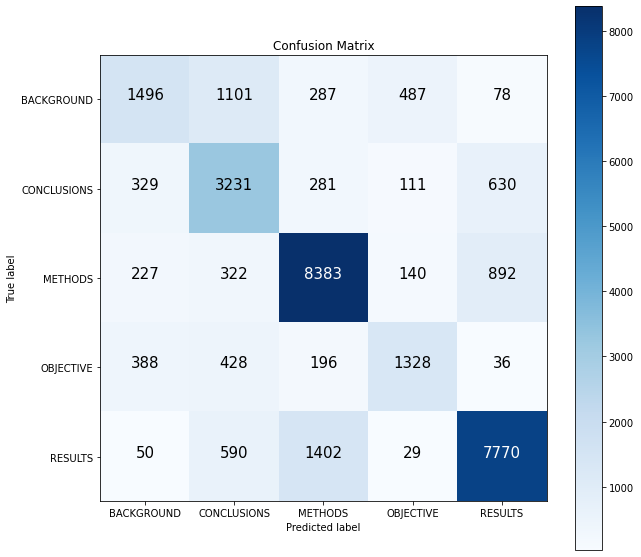

In [98]:
make_confusion_matrix(val_labels_encoded, model_4_preds, classes = list(class_names))

In [99]:
model_1_results

{'accuracy': 80.18337084602145,
 'precision': 0.8009132613884711,
 'recall': 0.8018337084602145,
 'f1': 0.8004339540693292}

## Feature Engineering

Taking non-obvious features from the data and encoding them numerically to help our model learn

How can we add extra sources of data to our model?

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [100]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


**Any engineered features used to train a model need to be available at test time. In our time the line numbers and total lines are available**

### Feature Engineering

* Taking non-obvious features from the data and encoding them numerically to help our model learn
* How can we add extra sources of data to our model?

### Create positional embeddings

In [105]:
# How many different line numbers are there?
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

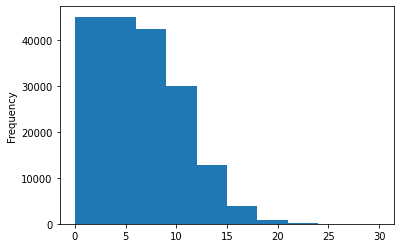

In [107]:
train_df.line_number.plot.hist();

In [126]:
# Use TensorFlow to create one-hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [109]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

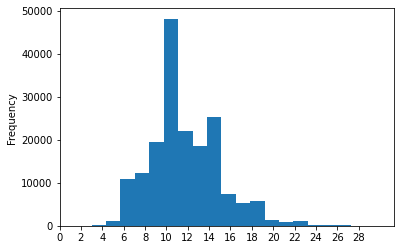

In [113]:
train_df.total_lines.plot.hist(bins = 20);
plt.xticks(np.arange(0, 30, 2));

In [127]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" features
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into tf.keras.Model

In [119]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape = (), dtype = tf.string, name = "token_input")
token_embeddings = feature_extractor(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = "relu", name = "token_output")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name = "token_model")

# 2. Character inputs
char_inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, name = "bi-LSTM_layer"))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm, name = "char_model")

# 3. Line numbers model
line_number_input = tf.keras.layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_input")
line_number_out = tf.keras.layers.Dense(32, activation = "relu", name = "line_number_out")(line_number_input)
line_number_model = tf.keras.Model(line_number_input, line_number_out, name = "line_number_model")

# 4. Total lines model
total_lines_input = tf.keras.layers.Input(shape = (20, ), dtype = tf.float32, name = "total_lines_input")
total_lines_out = tf.keras.layers.Dense(32, activation = "relu", name = "total_lines_out")(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input, total_lines_out, name = "total_lines_model")

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output, char_model.output])

z = tf.keras.layers.Dense(256, activation = "relu")(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = tf.keras.layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input, total_lines_model.input, token_model.input, char_model.input], outputs = output_layer, name = "tribrid_model_5")

In [120]:
model_5.summary()

Model: "tribrid_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]

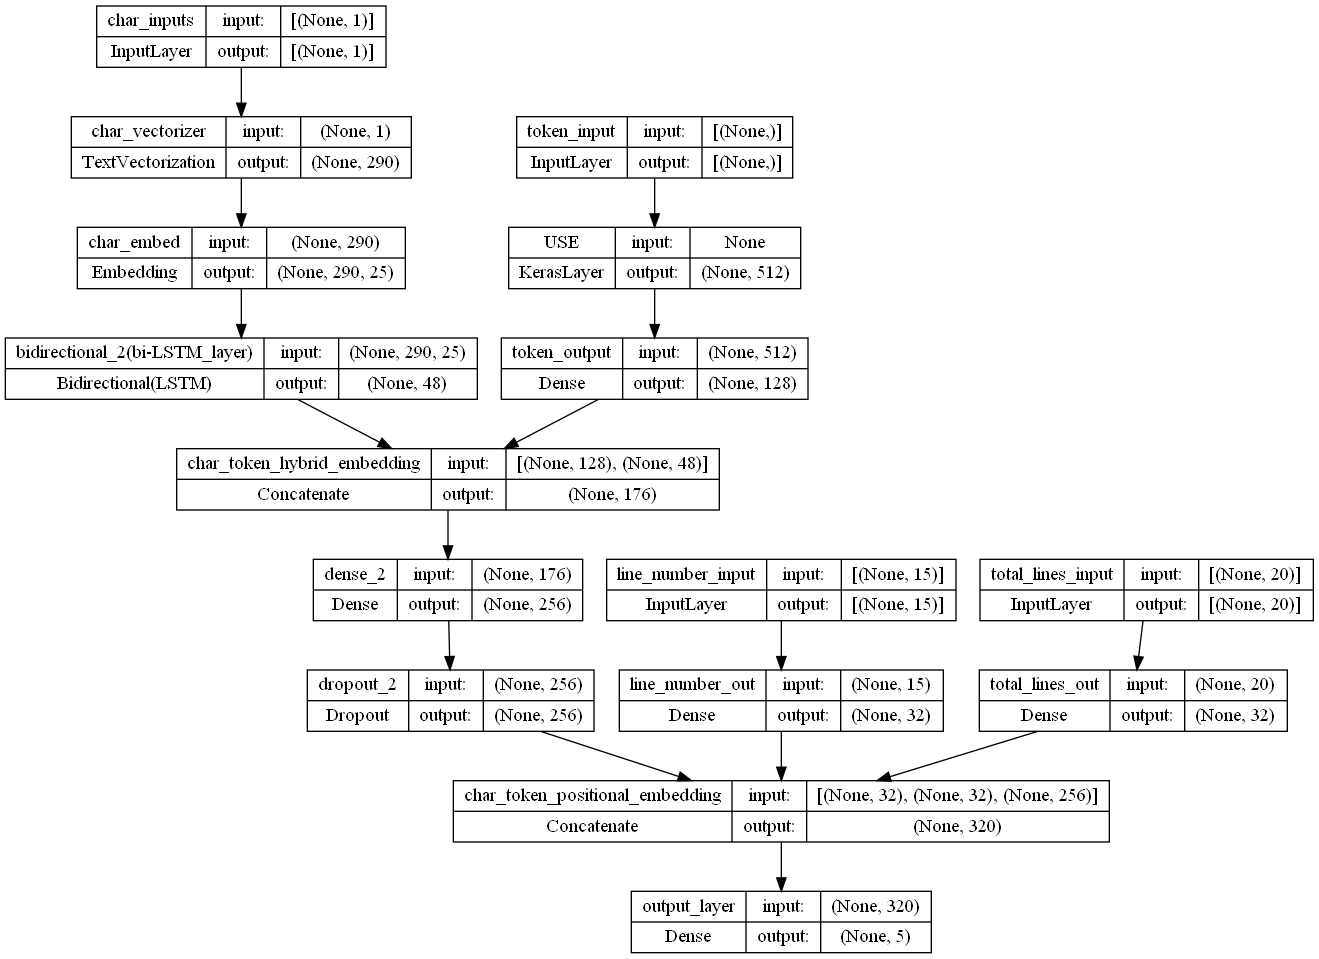

In [121]:
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example is our model gets too confident on a single class (eg its predictions probability is really high), it may get stuck at that class and not consider other classes

What label smoothing does is it assigns some of the value from the highest pred prob to other classes in turn hopefully improving generalisation

> For more on label smoothing, see the blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [122]:
# Compile token, char and positional embedding model
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

### Create tribrid embedding datasets using tf.data

In [123]:
def create_tribrid_dataset(line_numbers_one_hot, total_lines_one_hot, token_sequence, char_sequence, label_data, batch_size = 32):
    char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_numbers_one_hot, total_lines_one_hot, token_sequence, char_sequence))
    label = tf.data.Dataset.from_tensor_slices(label_data)
    char_token_pos_dataset = tf.data.Dataset.zip((char_token_pos_data, label))
    char_token_pos_dataset = char_token_pos_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return char_token_pos_dataset

In [128]:
train_char_token_pos_dataset = create_tribrid_dataset(train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars, train_labels_one_hot)
val_char_token_pos_dataset = create_tribrid_dataset(val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars, val_labels_one_hot)
test_char_token_pos_dataset = create_tribrid_dataset(test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars, test_labels_one_hot)

len(train_char_token_pos_dataset), len(val_char_token_pos_dataset), len(test_char_token_pos_dataset)

(5627, 945, 942)

In [129]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [131]:
# Fitting the model
history_model_5 = model_5.fit(
    train_char_token_pos_dataset,
    epochs = 3,
    steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
    validation_data = val_char_token_pos_dataset,
    validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_5_skimlit_tribrid_embeddings")]
)

Saving TensorBoard log files to: TensorBoard/SkimLit/model_5_skimlit_tribrid_embeddings/20220721-104953
Epoch 1/3
562/562 [==============================] - 52s 78ms/step - loss: 1.0982 - accuracy: 0.7232 - val_loss: 0.9841 - val_accuracy: 0.8078
Epoch 2/3
562/562 [==============================] - 40s 72ms/step - loss: 0.9697 - accuracy: 0.8139 - val_loss: 0.9516 - val_accuracy: 0.8314
Epoch 3/3
562/562 [==============================] - 41s 72ms/step - loss: 0.9532 - accuracy: 0.8224 - val_loss: 0.9406 - val_accuracy: 0.8311


In [132]:
# Make predictions with the model
model_5_preds = tf.squeeze(tf.argmax(model_5.predict(val_char_token_pos_dataset), axis = 1))
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

945/945 [==============================] - 46s 47ms/step


{'accuracy': 83.12591023434396,
 'precision': 0.8303312330932977,
 'recall': 0.8312591023434397,
 'f1': 0.8303079695226957}

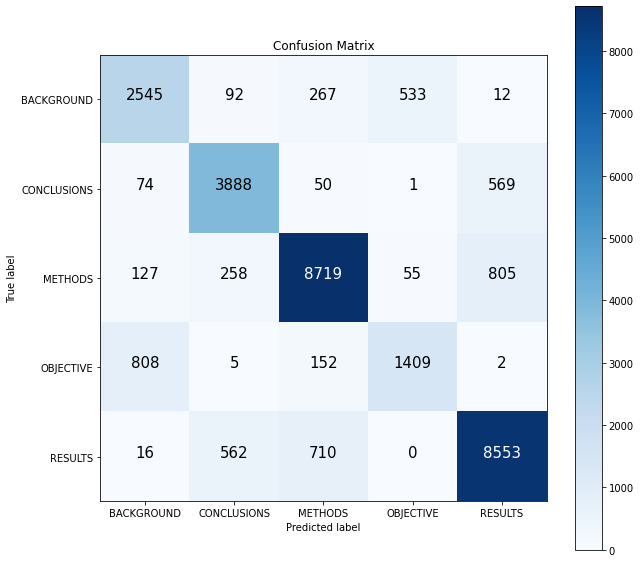

In [133]:
make_confusion_matrix(val_labels_encoded, model_5_preds, classes = list(class_names))

Wow! This is groundbreaking.

In [137]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({
    "model_0_baseline": baseline_results,
    "model_1_custom_token_embedding": model_1_results,
    "model_2_pretrained_token_embedding": model_2_results,
    "model_3_custom_char_embedding": model_3_results,
    "model_4_hybrid_char_token": model_4_results,
    "model_5_pos_char_token_embedding": model_5_results
})
all_model_results = all_model_results.transpose()

In [138]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

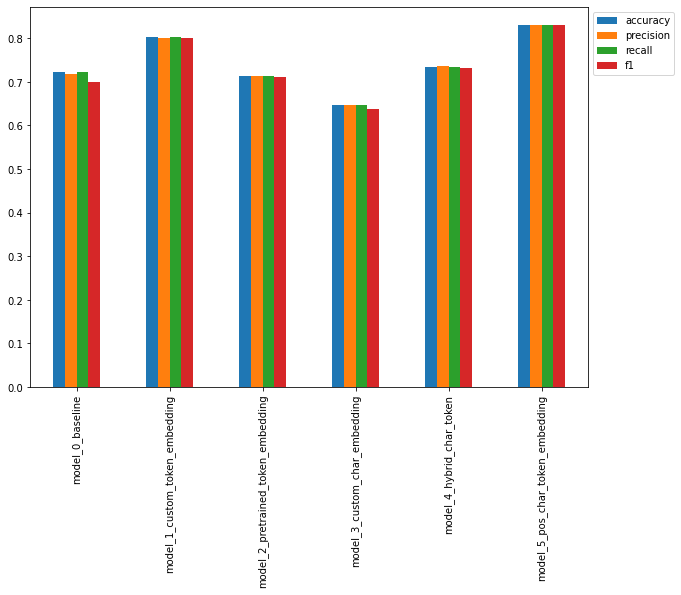

In [139]:
# Plot and compare all model results
all_model_results.plot(kind = "bar", figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

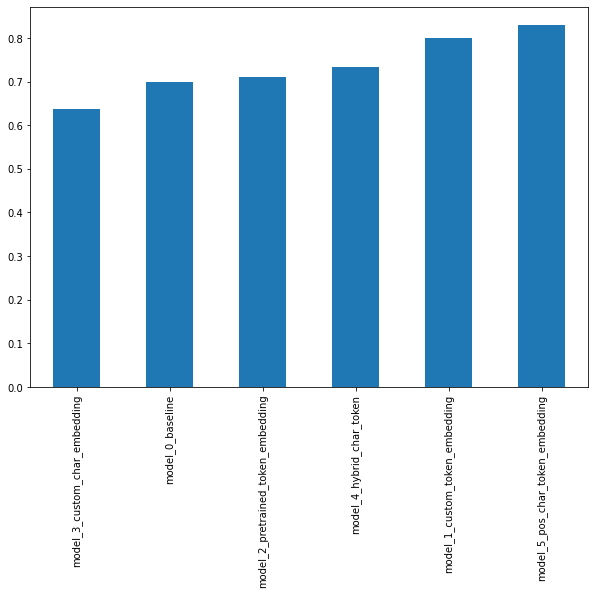

In [141]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending = True)["f1"].plot(kind = "bar", figsize = (10, 7));

In [142]:
model_5.save("Models/NLP/SkimLit/skimlit_tribrid_model")

INFO:tensorflow:Assets written to: Models/NLP/SkimLit/skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: Models/NLP/SkimLit/skimlit_tribrid_model\assets


In [143]:
loaded_model_5 = tf.keras.models.load_model("Models/NLP/SkimLit/skimlit_tribrid_model")

In [144]:
loaded_preds = tf.argmax(loaded_model_5.predict(val_char_token_pos_dataset), axis = 1)
loaded_results = calculate_results(val_labels_encoded, loaded_preds)
loaded_results

945/945 [==============================] - 44s 46ms/step


{'accuracy': 83.12591023434396,
 'precision': 0.8303312330932977,
 'recall': 0.8312591023434397,
 'f1': 0.8303079695226957}